In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-03 06:22:02--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-03 06:22:02 (6.01 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [19]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [20]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1  for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [88]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [45]:
# training split , dev/validation split , test split
# 80% , 10% , 10%

block_size=8 # context length , how many characters  do we take to predict the next one
def build_dataset(words):
  #build the dataset
  X,Y = [],[]

  for w in words:
    context=block_size*[0]
    for ch in w + ".":
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)

      context=context[1:]+[ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)

  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [89]:
class Linear:

  def __init__(self,fan_in,fan_out,bias=True):
    self.weight=torch.randn((fan_in,fan_out),generator=g)/(fan_in**0.5)  #kaiming initialization
    self.bias=torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out=x@self.weight
    if self.bias is not None:
      self.out+=self.bias

    return self.out


  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])

#--------------------------------------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self,dim,eps=1e-5,momentum=1e-1):
    self.eps=eps
    self.momentum=momentum

    self.training=True

    #parameters(trained with backprop)

    self.gamma=torch.ones(dim)
    self.beta=torch.zeros(dim)

    #buffers(trained with a running ' momentun update')
    self.running_mean=torch.zeros(dim)
    self.running_var=torch.ones(dim)


  def __call__(self,x):
    #calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim=0
      elif x.ndim == 3:
        dim=(0,1)
      xmean=x.mean(dim,keepdim=True) #batch mean
      xvar=x.var(dim,keepdim=True)   #batch variance
    else :
      xmean=self.running_mean
      xvar=self.running_var

    xhat=(x-xmean)/torch.sqrt(xvar+self.eps)  #normalize to unit variance

    self.out=self.gamma*xhat+self.beta

    #update the buffers

    if self.training:
      with torch.no_grad(): # torch.no grad context manager so that pytorch does not create a computational graph. This saves memory
        self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var=(1-self.momentum)*self.running_var+ self.momentum*xvar

    return self.out


  def parameters(self):
    return [self.gamma,self.beta]

#--------------------------------------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self,x):
    self.out=torch.tanh(x)
    return self.out

  def parameters(self):
    return []
#--------------------------------------------------------------------------------------------------------------------------

class Embedding:

  def __init__(self,num_embeddings,embedding_dim):
    self.weight=torch.randn((num_embeddings,embedding_dim))


  def __call__(self,IX):
    self.out=self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

#--------------------------------------------------------------------------------------------------------------------------


class FlattenConsecutive:

  def __init__(self,n):
    self.n=n

  def __call__(self,x):
    B,T,C=x.shape

    x=x.view(B, T//self.n ,C*self.n)

    if x.shape[1] == 1:
      x=x.squeeze(1)
    self.out=x

    return self.out


  def parameters(self):
    return []

#--------------------------------------------------------------------------------------------------------------------------

class Sequential:

  def __init__(self,layers):
    self.layers=layers


  def __call__(self,x):

    for layer in self.layers:
      x=layer(x)

    self.out=x
    return self.out

  def parameters(self):

    # get parameters of all the layers and stretch them into one list

    return [p for layer in self.layers for p in layer.parameters()]


In [90]:
n_embed=10 # the dimensonality of character embedding vectors
n_hidden=68 # the number of neurons in the hidden layer of MLP
g= torch.Generator().manual_seed(2147483647)


model=Sequential([
    Embedding(vocab_size,n_embed),

    FlattenConsecutive(2),Linear(n_embed*2,n_hidden,bias=False),BatchNorm1d(n_hidden), Tanh(),

    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden), Tanh(),

    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
  # last layer : make less confident
  model.layers[-1].weight*=0.1

parameters=model.parameters()

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True


22397


In [91]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]
for i in range(max_steps):

  #minibatch construct

  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix]


  #forward pass
  logits=model(Xb)
  loss=F.cross_entropy(logits,Yb)

  #backward pass

  for layer in model.layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad=None

  loss.backward()

  #update

  lr= 1e-1 if i <100000 else 1e-2

  for p in parameters:
    p.data+=-lr*p.grad





  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break




      0/ 200000: 3.2908
  10000/ 200000: 2.2669
  20000/ 200000: 1.8132
  30000/ 200000: 1.7732
  40000/ 200000: 1.9359
  50000/ 200000: 2.1358
  60000/ 200000: 2.4044
  70000/ 200000: 1.9941
  80000/ 200000: 1.6291
  90000/ 200000: 1.8505
 100000/ 200000: 2.1045
 110000/ 200000: 1.5991
 120000/ 200000: 1.9762
 130000/ 200000: 2.4629
 140000/ 200000: 2.0382
 150000/ 200000: 2.0637
 160000/ 200000: 2.0488
 170000/ 200000: 2.0086
 180000/ 200000: 2.1395
 190000/ 200000: 1.6867


In [92]:
for layer in model.layers:
  print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


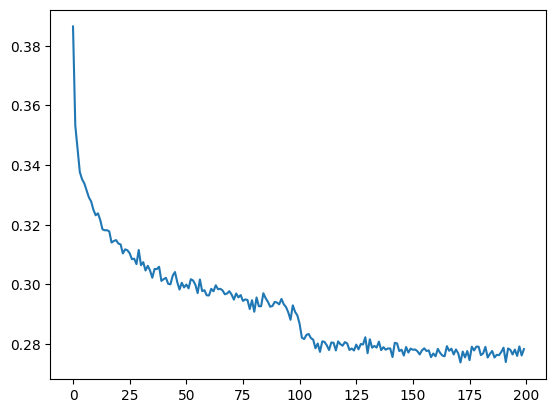

In [93]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [94]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits=model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.8757989406585693
val 2.2567098140716553


In [ ]:
for layer in model.layers:
  print(layer.training)
  # layer.training=False

In [95]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net

      logits=model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

monailah.
zhayel.
nihaya.
arethan.
ejdra.
graxce.
daelin.
shivaea.
edelie.
maxar.
katuillous.
caysha.
vrishima.
stone.
renelle.
novalyn.
brenden.
jamell.
elsy.
majaya.


# DEBUGGING

In [66]:
model.layers[0].out.shape  # output of the Embedding layer

torch.Size([4, 8, 10])

In [67]:
model.layers[1].out.shape  # output of Flatten layer

torch.Size([4, 80])

In [68]:
model.layers[2].out.shape  # output of  Linear layer

torch.Size([4, 200])

In [54]:
(torch.randn(4,4,20)@torch.randn(20,200) +torch.randn(200)).shape

torch.Size([4, 4, 200])

In [55]:
# (1,2)  (3,4)  (5,6)  (7,8)

In [56]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [57]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [58]:
e=torch.randn(4,8,10) # goal want this to be (4,4,20 ) where consecutive 10-dimensional vectors get concatenated

explicit=torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [60]:
(e.view(4,4,20) == explicit).all()

tensor(True)